In [224]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import sys, os, copy
sys.path.insert(0,r"C:\Users\nanw0\GoogleDrive\SLAC\SLAC-Diling\8. 20 Winter\Beam_propagation\WPG\WPG-develop")
sys.path.insert(0,os.path.join('..','..'))

import time
import numpy as np
import pylab as plt

# import auxiliar functions
from Auxiliary import *


In [232]:
''' Silicon 111 crystal '''
# dafault crystal parameters
d_sp = 3.13557135638            # reflecting plane d-spacing [A]
psi0r = -5.11321939903e-05      # real part of 0th Fourier component of crystal polarizability
psi0i = 3.58887560736e-06       # imaginary part of ""
psi_hr = -2.71341902391e-05     # real part of Hth Fourier component
psi_hi = 2.50565837652e-06      # imaginary part of ""
psi_hbr = -2.71341902391e-05    # real part of -Hth Fourier coumponent
psi_hbi = 2.50565837652e-06     # imaginary part of ""
tc = 0.01                       # crystal thickness
ang_as = np.deg2rad(5)          # asymmetric angle
uc = 1                          # use case: 1 (Bragg reflection); 2 (Bragg transmission)

ang_dif_pl = 0                  # diffraction plane angle: 0 (vertical); pi/2 (horizontal)
Temp_Crystal = SRWLOptCryst(d_sp,psi0r,psi0i,psi_hr,psi_hi,psi_hbr,psi_hbi,tc,ang_as,_uc=uc)

# lens parameters (PMMA)
n = 1 - 5.89e-6         # material refractive index
#d_abs = 788e-6          # material absorption depth
d_abs = 3000e-6
f_lens = 1              # lens focal distance

# aperture parameters
Apt_width = 1.0e-6      # aperture width (1D)
acentx = 0              # center of aperture [m]
acenty = 0

''' incident beam variables '''
ekev = 10.0                 # photon energy [kev]
pulse_duration = 50e-15    # pulse duration (rms) [t]
z1 = 200.0                  # distance to first OE [m]
sigX = 30e-6                # w0 (rms) [m]
npoints = 2000              # wavefront sampling dimension
if_load_input = 0           # load (1) or generate (0) incident wavefront

# default values
qnC = 0.1                   # charge [nC]
pulseEnergy = 0.5e-3        # pulse energy [J]
dt = 0.5e-15                # time sampling resolution
if pulse_duration/dt <= 10:
    print('incident beam too short, changing to finer sampling resolution ...')
    dt = 0.1e-15
    if pulse_duration/dt <= 10:
        print(".... okay, the beam is really too short, simulation might break down")
hbar = 6.582119569e-16


In [233]:
''' calculations '''
wl0 = E2L(ekev*1e3)                 # wavelength
k0 = 2*np.pi/wl0                    # wavenumber
divergence = wl0/np.pi/sigX         # paraxial beam divergence (rms)
range_xy = divergence/2 * z1 * 5    # spatial sampling range (5 sigma)

nvx0, nvy0, nvz0 = Temp_Crystal.find_orient(ekev*1e3,ang_dif_pl)[0][2]
thetaB0 = np.arctan(-nvz0/nvy0)+ang_as

trange = calc_stretching(thetaB0, ang_as, range_xy)    # stretched pulse duration
dev = 1/trange * 2*np.pi * hbar     # photon energy sampling resolution
nz = int(trange/dt)                 # number of photon energy slices
if nz % 2!=0:
    nz += 1
pulseRange = trange/pulse_duration

In [234]:
''' diffraction limit and focal spot Rayleigh range '''
thetamax = 2*np.arctan(divergence/2*z1*3/f_lens)
dlim = wl0/2/n/np.sin(thetamax)     # diffraction limit
zR = 1/2 * k0 * dlim**2             # focal spot Rayleigh range

print('beam parameters:\n    {}keV, {}fs, {}um w0, {}urad divergence'.format(
    ekev, round(pulse_duration*1e15,2), round(sigX*1e6,2), round(divergence*1e6,2)))
print('sampling parameters:\n    {}fs dt, {}meV deV, {} nz, {} pulseRange'.format(
    round(dt*1e15,2), round(dev*1e3,2), nz, round(pulseRange,2)))
print('other parameters:\n    Bragg angle {}deg, stretched pulse length {}fs'.format(
    round(np.rad2deg(thetaB0),2),round(trange*1e15,2)))
print('diffraction limit {}um, Rayleigh range {}mm'.format(round(dlim*1e6,2),round(zR*1e3,2)))



beam parameters:
    10.0keV, 50.0fs, 30.0um w0, 1.32urad divergence
sampling parameters:
    0.5fs dt, 6.11meV deV, 1354 nz, 13.55 pulseRange
other parameters:
    Bragg angle 11.42deg, stretched pulse length 677.4fs
diffraction limit 0.08um, Rayleigh range 0.16mm


In [235]:
''' plot directories '''
strDataFolderName = 'WPG_output/Hasan_Mono/' 
dirname_duration = strDataFolderName+'{}kev_{}fs_beam_dt={}fs_dev={}meV/'.format(
    ekev,round(pulse_duration*1e15,1),round(dt*1e15,2),round(dev*1e3,2))

dirname_input = dirname_duration+'incident_beam/'
dirname_prop = dirname_duration+'propagation/'

''' load wavefronts '''
fname_incident = dirname_input + 'incident_wavefront.h5'
fname_l0 = dirname_prop + '1_wavefront_on_l0_{}um_slit.h5'.format(round(Apt_width*1e6,2))
fname_apt = dirname_prop + '2_wavefront_on_slit_{}um_slit.h5'.format(round(Apt_width*1e6,2))
fname_l1 = dirname_prop + '3_wavefront_on_l1_{}um_slit.h5'.format(round(Apt_width*1e6,2))
fname_c2 = dirname_prop + '4_wavefront_on_c2_{}um_slit.h5'.format(round(Apt_width*1e6,2))
fname_det = dirname_prop + '5_wavefront_on_det_{}um_slit.h5'.format(round(Apt_width*1e6,2))

mwf = Wavefront(); mwf.load_hdf5(fname_incident)
mwf_l0 = Wavefront(); mwf_l0.load_hdf5(fname_l0)
mwf_apt = Wavefront(); mwf_apt.load_hdf5(fname_apt)
mwf_l1 = Wavefront(); mwf_l1.load_hdf5(fname_l1)
mwf_c2 = Wavefront(); mwf_c2.load_hdf5(fname_c2)
mwf_det = Wavefront(); mwf_det.load_hdf5(fname_det)


### Plot

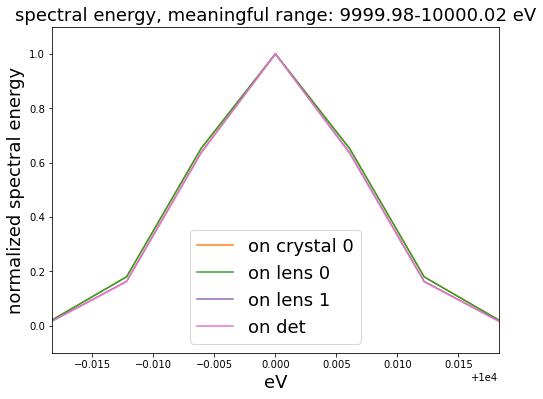

In [236]:
''' spectra everywhere '''
plt.figure(figsize=(8,6))
awc0, evc0, intc0s = plot_spectra(mwf, 'C1', label='on crystal 0')
awl0, evl0, intl0s = plot_spectra(mwf_l0, 'C2', label='on lens 0')
awl1, evl1, intl1s = plot_spectra(mwf_l1, 'C4', label='on lens 1')
awdet, evdet, intdets = plot_spectra(mwf_det,'C6', label='on det')
plt.xlim([evc0[awc0.min()],evc0[awc0.max()]])
plt.savefig(dirname_prop+'spectra.png_{}um_slit.png'.format(
    round(Apt_width*1e6,2)),transparent=True)


R-space
R-space
R-space
R-space
R-space
R-space


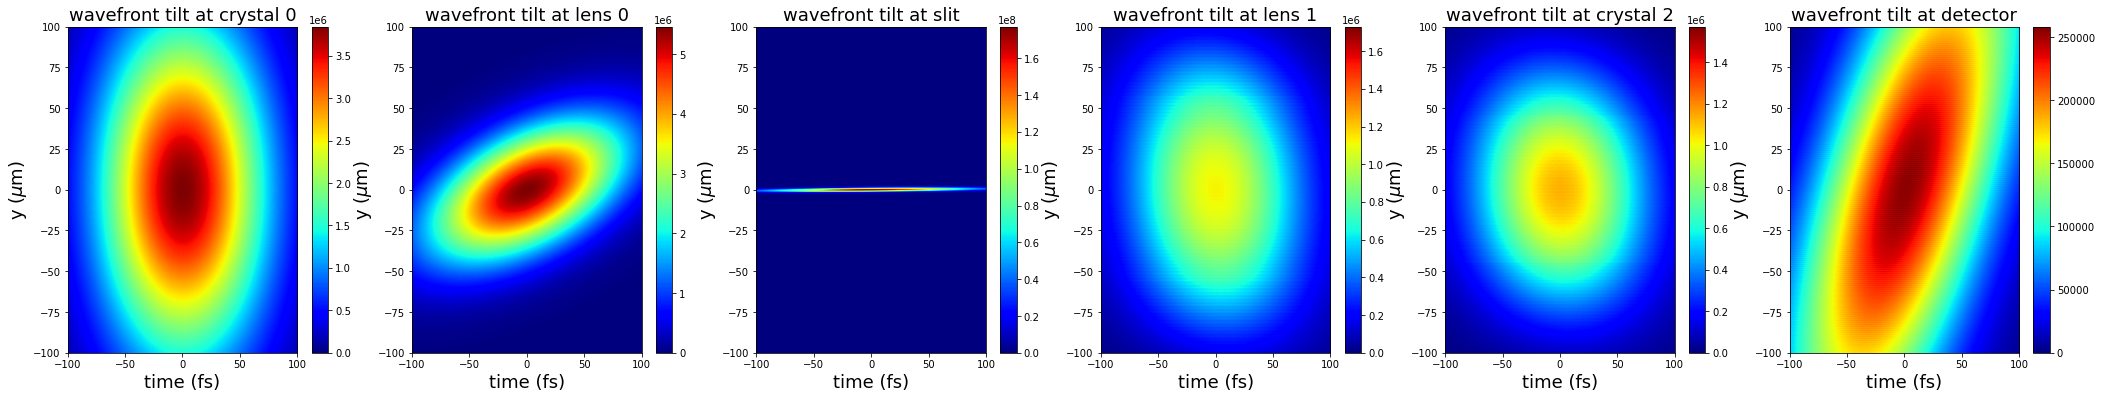

In [237]:
''' wavefront profile everywhere '''
ori = 'V'
fov_y = 200    # um
fov_t = 200    # fs
plt.figure(figsize=(36,6))
plt.subplot(1,6,1)
plot_tilt(mwf, 'C1', label='crystal 0',ori=ori)
plt.xlim([-fov_t/2,fov_t/2]); plt.ylim([-fov_y/2,fov_y/2])
plt.subplot(1,6,2)
plot_tilt(mwf_l0, 'C2', label='lens 0',ori=ori)
plt.xlim([-fov_t/2,fov_t/2]); plt.ylim([-fov_y/2,fov_y/2])
plt.subplot(1,6,3)
plot_tilt(mwf_apt, 'C3', label='slit',ori=ori)
plt.xlim([-fov_t/2,fov_t/2]); plt.ylim([-fov_y/2,fov_y/2])
plt.subplot(1,6,4)
plot_tilt(mwf_l1, 'C4', label='lens 1',ori=ori)
plt.xlim([-fov_t/2,fov_t/2]); plt.ylim([-fov_y/2,fov_y/2])
plt.subplot(1,6,5)
plot_tilt(mwf_c2, 'C5', label='crystal 2',ori=ori)
plt.xlim([-fov_t/2,fov_t/2]); plt.ylim([-fov_y/2,fov_y/2])
plt.subplot(1,6,6)
plot_tilt(mwf_det, 'C6', label='detector',ori=ori)
plt.xlim([-fov_t/2,fov_t/2]); plt.ylim([-fov_y/2,fov_y/2])

plt.savefig(dirname_prop+'wavefront_tilt_{}um_slit.png'.format(
    round(Apt_width*1e6,2)),transparent=True)

R-space
R-space
R-space
R-space
R-space
R-space


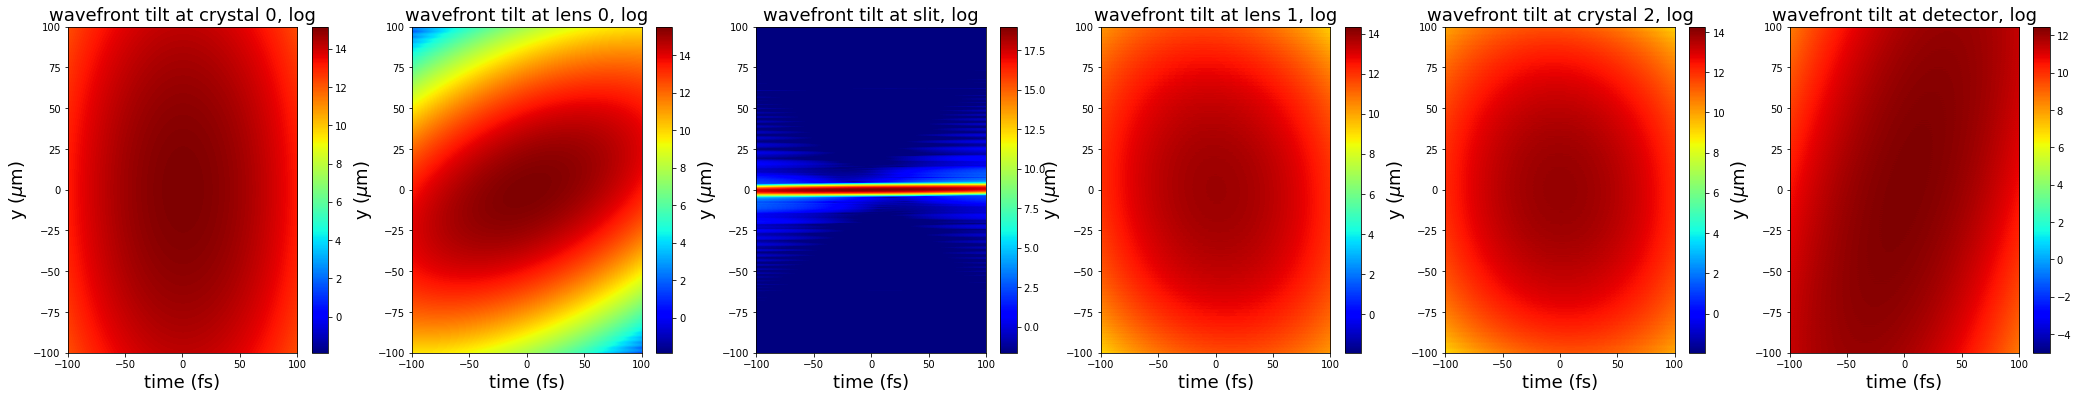

In [238]:
''' wavefront profile everywhere log '''
ori = 'V'
if_log = 1
fov_y = 200    # um
fov_t = 200    # fs
plt.figure(figsize=(36,6))
plt.subplot(1,6,1)
plot_tilt(mwf, 'C1', label='crystal 0',ori=ori, if_log=if_log)
plt.xlim([-fov_t/2,fov_t/2]); plt.ylim([-fov_y/2,fov_y/2])
plt.subplot(1,6,2)
plot_tilt(mwf_l0, 'C2', label='lens 0',ori=ori, if_log=if_log)
plt.xlim([-fov_t/2,fov_t/2]); plt.ylim([-fov_y/2,fov_y/2])
plt.subplot(1,6,3)
plot_tilt(mwf_apt, 'C3', label='slit',ori=ori, if_log=if_log)
plt.xlim([-fov_t/2,fov_t/2]); plt.ylim([-fov_y/2,fov_y/2])
plt.subplot(1,6,4)
plot_tilt(mwf_l1, 'C4', label='lens 1',ori=ori, if_log=if_log)
plt.xlim([-fov_t/2,fov_t/2]); plt.ylim([-fov_y/2,fov_y/2])
plt.subplot(1,6,5)
plot_tilt(mwf_c2, 'C5', label='crystal 2',ori=ori, if_log=if_log)
plt.xlim([-fov_t/2,fov_t/2]); plt.ylim([-fov_y/2,fov_y/2])
plt.subplot(1,6,6)
plot_tilt(mwf_det, 'C6', label='detector',ori=ori, if_log=if_log)
plt.xlim([-fov_t/2,fov_t/2]); plt.ylim([-fov_y/2,fov_y/2])
plt.clim(-5)
plt.savefig(dirname_prop+'wavefront_tilt_{}um_slit_log.png'.format(
    round(Apt_width*1e6,2)),transparent=True)